# Potato Disease Classification (Early & Late Blight Detection)

### Importing  Dependencies 

In [84]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Setting constant values

In [85]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50 

### Importing data into TF dataset object

Use "image_dataset_from_directory" API  to load all images in TF dataset.

In [27]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [28]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

### Visualing Images from our dataset

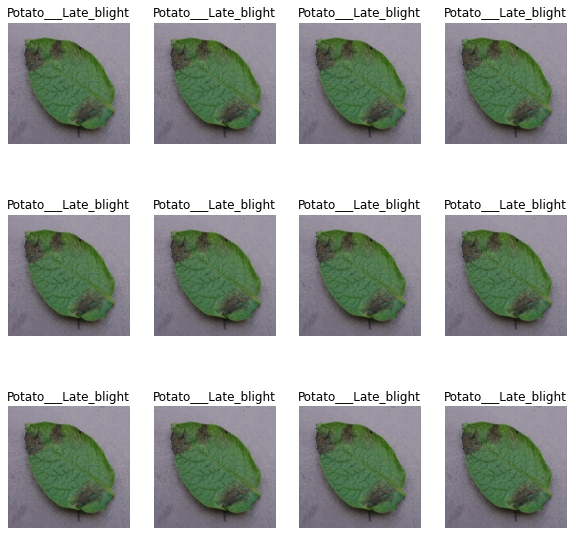

In [29]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        subplot = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[0]])
        plt.axis("off")

### Function to Split Dataset
Dataset is divided into 3 subsets:

- Training: Dataset to be used while training<br>
- Validation: Dataset to be tested against while training<br>
- Test: Dataset to be tested against after we trained a model

In [30]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [31]:
training_ds = dataset.take(54)
len(training_ds)

54

In [32]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [33]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [34]:
validation_ds = test_ds.take(6)
len(validation_ds)

6

In [35]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [36]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, validation_ds, test_ds

In [37]:
train_ds, validation_ds, test_ds = get_dataset_partitions_tf(dataset)

### Cache, Shuffle, and Prefetch the Dataset


In [38]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building Model

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model. <br>


In [39]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

### Data Augmentation


In [40]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

#### Convolutional neural network (CNN).


In [41]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (3,3), activation='relu', input_shape='input_shape'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'), 
])

model.build(input_shape=input_shape)


In [42]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (32, 30, 30, 64)         

### Model Compilation

 'adam' Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric



In [43]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [44]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=validation_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
54/54 [==============================] - 241s 4s/step - loss: 0.9006 - accuracy: 0.4948 - val_loss: 0.8077 - val_accuracy: 0.5162
Epoch 2/50
54/54 [==============================] - 190s 4s/step - loss: 0.6871 - accuracy: 0.6539 - val_loss: 0.5405 - val_accuracy: 0.7587
Epoch 3/50
54/54 [==============================] - 178s 3s/step - loss: 0.4548 - accuracy: 0.8061 - val_loss: 0.4091 - val_accuracy: 0.8623
Epoch 4/50
54/54 [==============================] - 176s 3s/step - loss: 0.3434 - accuracy: 0.8762 - val_loss: 0.2358 - val_accuracy: 0.9288
Epoch 5/50
54/54 [==============================] - 176s 3s/step - loss: 0.2061 - accuracy: 0.9277 - val_loss: 0.1136 - val_accuracy: 0.9549
Epoch 6/50
54/54 [==============================] - 206s 4s/step - loss: 0.2172 - accuracy: 0.9201 - val_loss: 0.1536 - val_accuracy: 0.9468
Epoch 7/50
54/54 [==============================] - 223s 4s/step - loss: 0.0984 - accuracy: 0.9647 - val_loss: 0.1566 - val_accuracy: 0.9416
Epoch 8/50
54

In [45]:
scores = model.evaluate(test_ds)

54/54 [==============================] - 40s 748ms/step - loss: 1.4872e-05 - accuracy: 1.0000


In [46]:
scores

[1.4872108295094222e-05, 1.0]

### Plotting Accuracy and Loss curves

In [47]:
history

In [48]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [49]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [50]:
history.history['loss'][:5] # show loss for first 5 epochs


[0.9005847573280334,
 0.6870948076248169,
 0.45478737354278564,
 0.34337833523750305,
 0.2060677707195282]

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

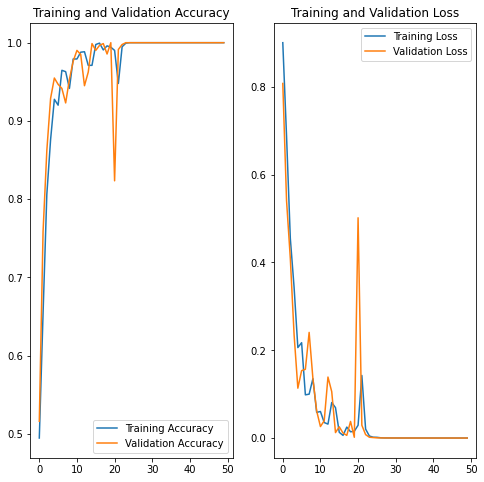

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Running prediction on sample Image

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


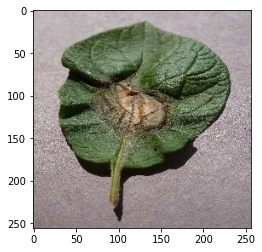

In [56]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Inference Function

In [58]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

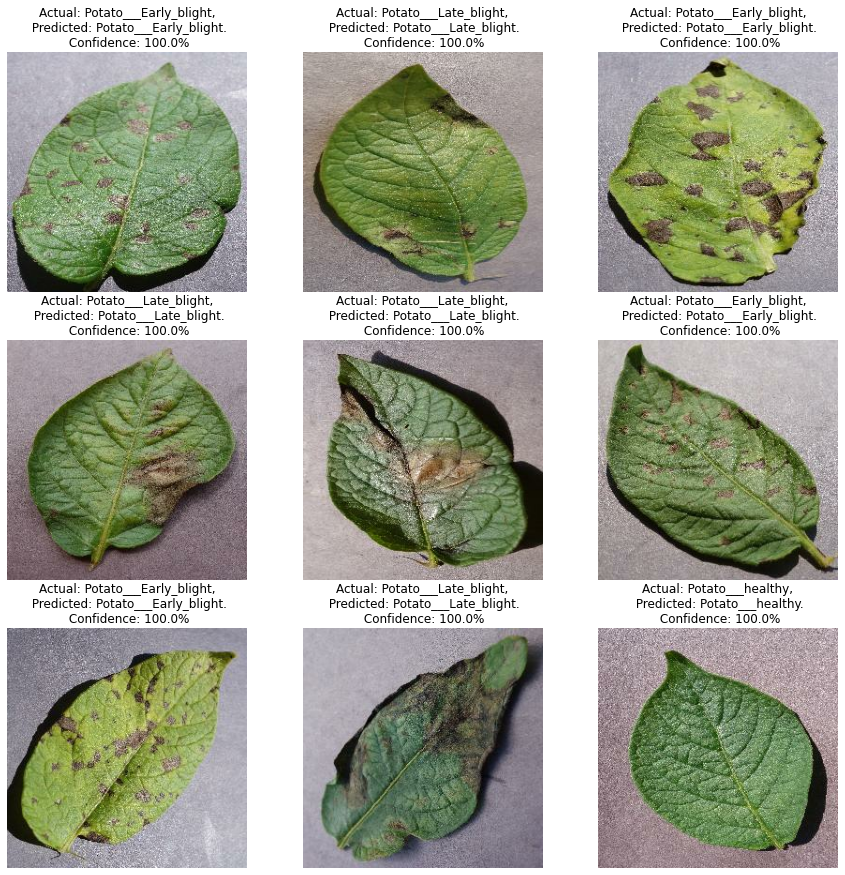

In [59]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model 

In [78]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


In [79]:
model.save("../potatoes.h5")